In [1]:
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if "/home/alex/qi3/hmmtuf" not in sys.path:
    sys.path.append("/home/alex/qi3/hmmtuf")

In [3]:
from db.sqlite3_db_connector import SQLiteDBConnector
from compute_engine.src.utils import count_kmers
from compute_engine.src.utils import INFO
from compute_engine.src.cpf import map_seq_to_category
from compute_engine.src.utils import get_max_kmers

In [4]:
# connect to the DB
db_connector = SQLiteDBConnector(db_file="../../play_ground.sqlite3")

In [5]:
MIN_REPEAT_LENGTH = 10
N_BEST_COUNTS = 'all'
KMERS_COUNT_AS_PERCENTAGE = True
TOP_KMERS_AS_PERCENTAGE = True
TOP_STATE_COUNTERS = 10
KMER_LENGTH = 4

In [6]:
def insert_or_update(kmers_old, kmers_new):
    
    for item in kmers_new:
        if item in kmers_old:
            kmers_old[item] += kmers_new[item]
        else:
            kmers_old[item] = kmers_new[item]
            
    return kmers_old
            

In [7]:
tbl_names = db_connector.get_table_names()
print("{0} DB table names: {1}".format(INFO, tbl_names))

INFO: DB table names: ['distance_metric_type', 'distance_sequence_type', 'repeats', 'hmm_state_types', 'repeats_distances', 'repeats_info', 'gquads_info']


In [8]:
print(db_connector.get_table_column_names(table_name='repeats'))

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'chromosome', 'TEXT', 1, None, 0), (2, 'start_idx', 'INT', 1, None, 0), (3, 'end_idx', 'INT', 1, None, 0), (4, 'repeat_seq', 'TEXT', 1, None, 0), (5, 'hmm_state_id', 'INTEGER', 1, None, 0), (6, 'gc', 'FLOAT', 0, None, 0)]


In [9]:
print(db_connector.get_table_column_names(table_name='repeats_info'))

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'chromosome', 'TEXT', 1, None, 0), (2, 'start_idx', 'INTEGER', 1, None, 0), (3, 'end_idx', 'INTEGER', 1, None, 0), (4, 'max_repeats_count', 'INTEGER', 1, None, 0), (5, 'align_seq', 'TEXT', 1, None, 0), (6, 'unit_seq', 'TEXT', 1, None, 0)]


In [10]:
# repeat sequences and their state
sql = "SELECT repeats_info.id, repeats_info.chromosome, repeats_info.start_idx, \
repeats_info.end_idx,  repeats_info.max_repeats_count, repeats_info.align_seq, repeats_info.unit_seq,\
repeats.hmm_state_id FROM repeats_info JOIN repeats WHERE  repeats.start_idx=repeats_info.start_idx AND \
repeats.end_idx=repeats_info.end_idx AND repeats_info.chromosome=repeats.chromosome"

In [11]:
repeats_info = db_connector.fetch_all(sql=sql)
print("{0} Number of repeats={1}".format(INFO, len(repeats_info)))

INFO: Number of repeats=4066


In [34]:
hmm_states = db_connector.fetch_from_hmm_state_types_all()
print("{0} HMM states {1}".format(INFO, hmm_states))

INFO: HMM states [(1, 'NORMAL'), (2, 'TUF'), (3, 'DELETION'), (4, 'DUPLICATION')]


In [13]:
hmm_states_map = dict()

for item in hmm_states:
    hmm_states_map[item[0]] = item[1]

In [14]:
total_repeats_kmers = {}

# for every repeat calculate the 
# the possible kmers
for repeat in repeats_info:
    
    repeat_id = repeat[0]
    repeat_chromosome = repeat[1]
    repeat_start_idx = repeat[2]
    repeat_end_idx = repeat[3]
    repeat_max_repeats_count = repeat[4]
    repeat_align_seq = repeat[5]
    repeat_unit_seq = repeat[6]
    region_hmm_state_id = repeat[7]
    
    if 'M' in repeat_align_seq or 'm' in repeat_align_seq:
        print("{0} Detected invalid align sequence ".format(INFO))
        continue
    # get the kmers for this repeat
    kmers = count_kmers(sequence=repeat_align_seq, k=KMER_LENGTH)
    top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
    total_repeats_kmers[repeat_id] = (top_kmers, hmm_states_map[region_hmm_state_id])
    

INFO: Detected invalid align sequence 


In [20]:
# collect the kmers per HMM state
total_kmers_per_state = {item[1]: {} for item in hmm_states}

# collect all the kmers count and the convert into
# percentage
for rid in total_repeats_kmers:
    kmers, hmm_state =  total_repeats_kmers[rid][0], total_repeats_kmers[rid][1]
    
    state_kmers = total_kmers_per_state[hmm_state]
    state_kmers = insert_or_update(kmers_old=state_kmers, kmers_new=kmers)
    total_kmers_per_state[hmm_state] = state_kmers

if KMERS_COUNT_AS_PERCENTAGE:
    
    total_kmers_count = 0
    for state in total_kmers_per_state:
        total_kmers_count += sum(total_kmers_per_state[state].values())
    
    print("{0} total kmers count {1}".format(INFO, total_kmers_count))
    
    # for every state scale the kmers count
    for state in total_kmers_per_state:
        for kmer in total_kmers_per_state[state]:
            total_kmers_per_state[state][kmer] /= total_kmers_count
    

INFO: total kmers count 1015229


In [21]:
for state in total_kmers_per_state:
    print("{0} state {1} has {2} kmers".format(INFO, state, len(total_kmers_per_state[state])))

INFO: state NORMAL has 256 kmers
INFO: state TUF has 256 kmers
INFO: state DELETION has 256 kmers
INFO: state DUPLICATION has 0 kmers


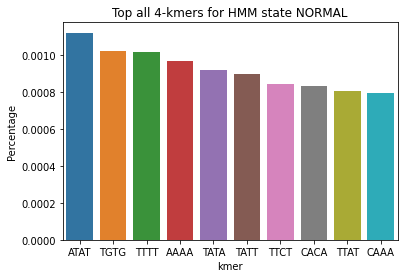

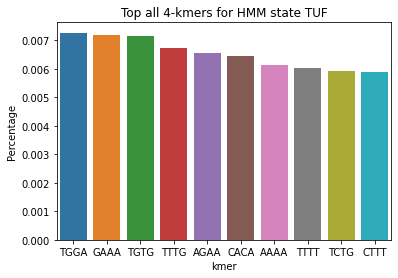

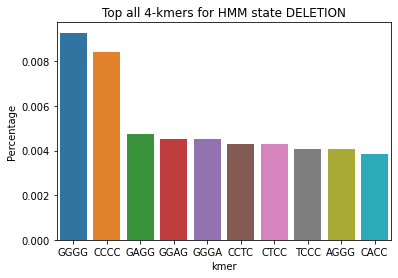

In [22]:

for state in total_kmers_per_state:
    
    if len(total_kmers_per_state[state]) == 0:
        continue
        
    # we have already converted into percentages
    # above with respect to the 
    top_state_kmers = get_max_kmers(total_kmers_per_state[state], min_count=TOP_STATE_COUNTERS)
    
    kmer_names = [name for name in top_state_kmers]
    frequencies = [top_state_kmers[item] for item in top_state_kmers]
    
    sns.barplot(x=kmer_names, y=frequencies)# palette=clrs)
    
    plt.ylabel('Percentage')
    plt.xlabel('kmer')
    plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
    plt.show()

In [24]:
categories = {'C1': {"R": ['A', 'G'], "Y": ["C", "T"]},
              'C2': {"M": ['A', 'C'], "K": ["G", "T"]},
              'C3': {"W": ['A', 'T'], "S": ["C", "G"]}}

In [25]:
# for every repeat calculate the
# kmers
count = 0
total_kmers_per_category = {}
for repeat in repeats_info:
    
    repeat_id = repeat[0]
    repeat_chromosome = repeat[1]
    repeat_start_idx = repeat[2]
    repeat_end_idx = repeat[3]
    repeat_max_repeats_count = repeat[4]
    repeat_align_seq = repeat[5]
    repeat_unit_seq = repeat[6]
    region_hmm_state_id = repeat[7]
    
    if 'M' in repeat_align_seq or 'm' in repeat_align_seq:
        continue
    
    total_kmers_per_category[repeat_id] = {}
    
    for c in categories:
       
        try:
            # get the kmers for this repeat
            kmers = count_kmers(sequence=map_seq_to_category(categories[c], seq=repeat_align_seq), k=KMER_LENGTH)
            top_kmers = get_max_kmers(kmers=kmers, min_count=N_BEST_COUNTS)
            total_kmers_per_category[repeat_id][c] = (top_kmers, hmm_states_map[region_hmm_state_id])
        except ValueError as e:
            print("{0} Category {1}".format(INFO, c))
            print("{0} Used sequence {1}".format(INFO,repeat_align_seq)) 
            print(str(e))
            
    

In [39]:
# collect the kmers per HMM state
# per category
total_kmers_per_state = dict()

for state in hmm_states:
    
    total_kmers_per_state[state[1]] = {}
    for c in categories:
        total_kmers_per_state[state[1]][c] = {}
        
# collect all the kmers count and the convert into
# percentage
for rid in total_kmers_per_category:
    for c in total_kmers_per_category[rid]:
        #print(rid)
        #print(c)
        #print(total_kmers_per_category[rid][c])
        kmers, hmm_state =  total_kmers_per_category[rid][c][0], total_kmers_per_category[rid][c][1]
    
        state_kmers = total_kmers_per_state[hmm_state][c]
        state_kmers = insert_or_update(kmers_old=state_kmers, kmers_new=kmers)
        total_kmers_per_state[hmm_state][c] = state_kmers

if KMERS_COUNT_AS_PERCENTAGE:
    
    total_kmers_count = {c: 0 for c in categories}
    for state in total_kmers_per_state:
        for c in categories: 
            total_kmers_count[c] += sum(total_kmers_per_state[state][c].values())
    
    print("{0} total kmers count {1}".format(INFO, total_kmers_count))
    
    # for every state scale the kmers count
    for state in total_kmers_per_state:
        for c in categories:
            for kmer in total_kmers_per_state[state][c]:
                total_kmers_per_state[state][c][kmer] /= total_kmers_count[c]

{'NORMAL': {'C1': {}, 'C2': {}, 'C3': {}}, 'TUF': {'C1': {}, 'C2': {}, 'C3': {}}, 'DELETION': {'C1': {}, 'C2': {}, 'C3': {}}, 'DUPLICATION': {'C1': {}, 'C2': {}, 'C3': {}}}
INFO: total kmers count {'C1': 1015229, 'C2': 1015229, 'C3': 1015229}


INFO: Working with state NORMAL


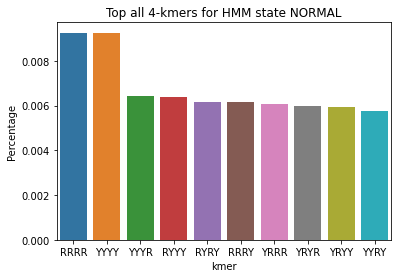

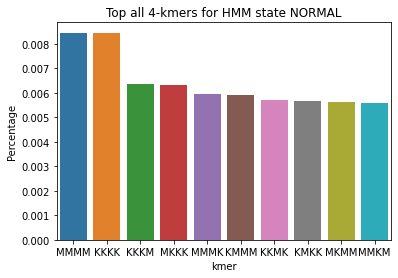

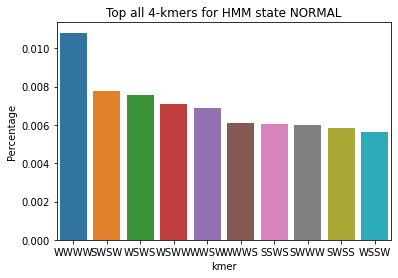

INFO: Working with state TUF


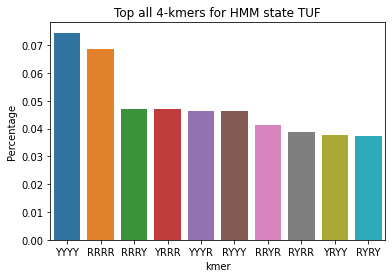

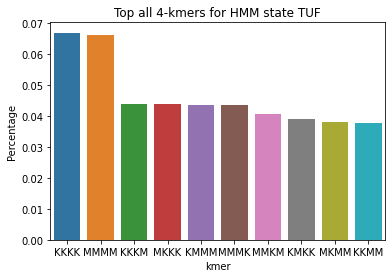

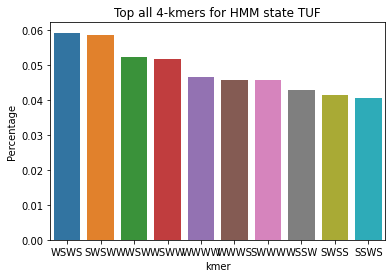

INFO: Working with state DELETION


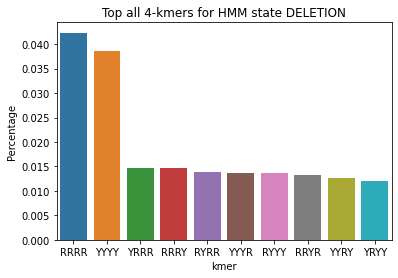

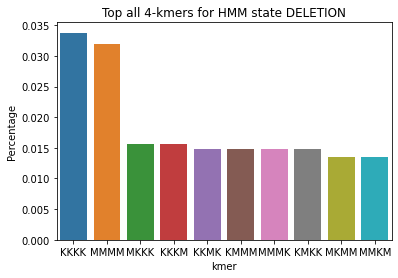

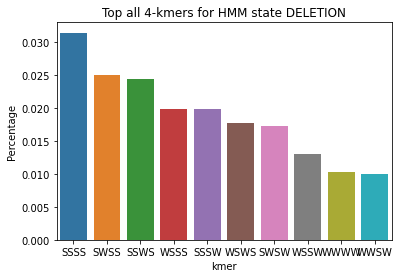

In [40]:
for state in total_kmers_per_state:
    
    if state == 'DUPLICATION':
        continue
        
    print("{0} Working with state {1}".format(INFO, state))
    
    
    for i, c in enumerate(categories):
    
        top_state_kmers = get_max_kmers(total_kmers_per_state[state][c], min_count=TOP_STATE_COUNTERS)
    
        kmer_names = [name for name in top_state_kmers]
        frequencies = [top_state_kmers[item] for item in top_state_kmers]
        
        #ax = sns.barplot(x=kmer_names, y=frequencies, ax=axs[i])
        sns.barplot(x=kmer_names, y=frequencies) #, ax=axs[i])
        
        plt.ylabel('Percentage')
        plt.xlabel('kmer')
        plt.title("Top {0} {1}-kmers for HMM state {2}".format(N_BEST_COUNTS, KMER_LENGTH, state))
        plt.show()